# Homework 6: Transformers and RNNs

## Setup of modules/helper code

In [1]:
# Model training related imports
import numpy as np
import torch
from torch.nn import TransformerEncoderLayer
from torch.nn.functional import softmax, relu
import math
from tqdm.auto import tqdm
from torch.nn.functional import cross_entropy
import time
import matplotlib.pyplot as plt

# Data loading and processing related imports
from io import open
import glob
import os
import unicodedata
import string

Defining Transformer Model

In [2]:
class TransformerModel(torch.nn.Module):
    def __init__(self, vocab_size, num_languages=18, max_seq_len=25, input_dim=64, fc_hidden_dim=128,
                 num_attn_heads=2, num_layers=1
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.dims = input_dim
        self.position_tensor = torch.arange(max_seq_len, dtype=torch.long) # (0, 1, ..., max_seq_len - 1)

        # Initialize embeddings
        self.positional_embedding = torch.nn.Embedding(max_seq_len, input_dim)
        self.token_embedding = torch.nn.Embedding(vocab_size, input_dim)
        
        # Handle category inputs
        self.category_embedding = torch.nn.Embedding(num_languages, input_dim)
        
        # Initialize transformer layers
        self.transformer = torch.nn.ModuleList()
        for i in range(num_layers):
            self.transformer.append(
                TransformerEncoderLayer(input_dim, num_attn_heads, fc_hidden_dim, dropout=0,)
            )
        # Initialize final prediction layer
        self.hidden_to_pred = torch.nn.Linear(input_dim, vocab_size)

        # Initialize weights
        with torch.no_grad():
            for w in [self.positional_embedding.weight, self.token_embedding.weight, 
                      self.category_embedding.weight, self.hidden_to_pred.weight]:
                rand_tensor = torch.randn_like(w)
                w.copy_(rand_tensor)
  
    @staticmethod
    def prepare_mask(seq_len):
        # TODO: What does this code do? 
        mask = torch.triu(torch.ones(seq_len, seq_len))  # (seq_len, seq_len)
        mask.masked_fill_(mask == 0, float('-inf')).masked_fill_(mask == 1, float(0.0))
        mask = mask.transpose(0, 1)
        return mask

    def forward(self, inputs, category):
        # inputs: (seq_len, batch_size); dtype = long (representing token ids)
        # category: (batch_size, num_languages)
        seq_len = inputs.shape[0]
        
        # Prepare mask and positions
        mask = self.prepare_mask(seq_len)  # (seq_len, seq_len)
        position_tensor = self.position_tensor[:seq_len]  # (0, 1, ..., seq_len - 1)

        # Embedding
        # TODO: what does this line of code do?
        token_embedding = self.token_embedding(inputs) * math.sqrt(self.dims)  # (seq_len, batch_size, embed_dim)
        
        # TODO: what does this line of code do?
        pos_embedding = self.positional_embedding(position_tensor) # (seq_len, embed_dim)
        pos_embedding = pos_embedding[:, None, :]  # (seq_len, 1, embed_dim); broadcast across batch
        
        category_embedding = self.category_embedding(category)  # (batch_size, embed_dim)
        category_embedding = category_embedding[None, :, :]  # (1, batch_size, embed_dim); broadcast across seq_len
        
        # TODO: what does this line of code do?
        total_embedding = token_embedding + pos_embedding + category_embedding # (seq_len, batch_size, embed_dim)
        hidden = relu(total_embedding)  # (seq_len, batch_size, embed_dim)
        
        # Apply transformer layers
        for transformer_layer in self.transformer:
            hidden = transformer_layer(hidden, mask)  # (seq_len, batch_size, embed_dim)

        # Get the final scores
        outputs = self.hidden_to_pred(hidden)  # (seq_len, batch_size, vocab_size)
        return outputs 


Loading data and processing it

In [3]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

# Turn a Unicode string to plain ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in glob.glob('../../Labs/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)

print(n_letters)

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
59


In [4]:
def input_to_indices(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(len(line))]
    return torch.LongTensor([letter_indexes]).T  # (seq_len, batch_size); batch_size = 1 

# LongTensor of second letter to end (EOS) for target
def target_to_indices(line):
    # Skip the first one and add EOS at the end
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor([letter_indexes]).T  # (seq_len, batch_size); batch_size = 1 


This is how we sample a single random example.

In [5]:
# Make category, input, and target tensors from a random category, line pair
def sample_one_example():
    # sample category
    category = np.random.choice(all_categories)
    category_tensor = torch.LongTensor([all_categories.index(category)])
    # sample line from category
    line = np.random.choice(category_lines[category]) 
    input_line_tensor = input_to_indices(line)
    target_line_tensor = target_to_indices(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [6]:
def train_sgd_one_pass(model, model2, total_num_examples, learning_rate, gamma):
    avg_loss = 0.0
    for i in tqdm(np.arange(total_num_examples)):  # ~2 min per epoch
        # sample a random training example
        category, input_line, target_line = sample_one_example()
        # Obtain predictions
        predictions = model(input_line, category)  # (seq_len, batch_size, vocab_size)
        
        # Compute the loss
        flattened_predictions = predictions.view(-1, predictions.shape[-1])  # (seq_len * batch_size, vocab_size)
        flattened_targets = target_line.view(-1)  # (seq_len * batch_size)
        loss = cross_entropy(flattened_predictions, flattened_targets)
        
        # Gradients and SGD update
        gradients = torch.autograd.grad(outputs=loss, inputs=model.parameters())
        
        # TODO: your code for the Gradients and SGD update
        with torch.no_grad():
            for param, grad in zip(model.parameters(), gradients):
                param -= learning_rate * grad
        
        # Adding exponential moving average
        with torch.no_grad():
            for p1, p2 in zip(model.parameters(), model2.parameters()):
                p2*= (1-gamma)
                p2+= gamma*p1
                
        avg_loss = i / (i+1) * avg_loss + loss.item() / (i+1)
        if i % 5000 == 0:
            print('\t\t', i, avg_loss)
    return avg_loss, model, model2

In [7]:
total_num_examples = sum([len(category_lines[c]) for c in all_categories])
print(total_num_examples)

20074


# Bonus 1: Preform averaged SGD using transformer architecture
Using the exact transformer model from Part 4 ("TransformerModel"), we will implement averaged SGD with an exponentially moving average. 
In addition to the model parameters $w_t$, we 
also maintain a separate set of parameters $\bar w_t$ to serve as an average. The updates of averaged SGD are
$$
    w_{t+1} = w_t - \eta g_t \\
    \bar w_{t+1} = (1 - \gamma) \bar w_t + \gamma w_{t+1},
$$
where $\eta$ is a learning rate, $g_t$ is a stochastic gradient at $w_t$ and $\gamma \in (0, 1)$ is an average weight. 

Some notes:
- the update of $w_t$ is identical to the regular SGD method. That is, the averaged parameter $\bar w_t$ is *not* used during the stochastic gradient updates. 
- The averaged parameter $\bar w_t$ is updated on the side and never to be used in model updates. We use $\bar w_t$ for logging only. 

Your task is to train the model for $10$ epochs and plot the train/test loss for both the unaveraged model $w_t$ as well as the averaged_model $\bar w_t$ in the same plot. You can use the function "compute_logs" below to calculate the loss. Use a learning_rate = 0.05 and do full SGD (not minibatch). We will use the average weight as $\gamma = 10^{-3}$.


**NOTE**: Do not include the logs of the first two passes through the data in the plot. This is because the inital loss is always very large and this tends to drown out the more interesting patterns we observe later on during training. 
 
    


In [8]:
def compute_loss(net):
    # Compute the loss
    category, input_line, target_line = sample_one_example()
    predictions = net(input_line, category)  # (seq_len, batch_size, vocab_size)
    flattened_predictions = predictions.view(-1, predictions.shape[-1])  # (seq_len * batch_size, vocab_size)
    flattened_targets = target_line.view(-1)  # (seq_len * batch_size)
    loss = cross_entropy(flattened_predictions, flattened_targets)
    return loss
    
def compute_logs(net, verbose=False):
    train_loss = compute_loss(net)
    test_loss = compute_loss(net)
    if verbose:
        print(('Train Loss = {:.3f}, ' + 
               'Test Loss = {:.3f},').format(
                train_loss.item(), 
                test_loss.item())
    )
    return (train_loss.item(), test_loss.item())

In [9]:
model = TransformerModel(vocab_size=n_letters)
learning_rate = 0.05

from copy import deepcopy
model_avg = deepcopy(model)

gamma = 1e-3
start = time.time()

logs = []
logs_avg = []

for epoch in range(10):
    t1 = time.time()
    print(f'Starting epoch {epoch}')
    avg_loss, model, model_avg = train_sgd_one_pass(model, model_avg, total_num_examples, learning_rate, gamma)
    logs.append(compute_logs(model))
    logs_avg.append(compute_logs(model_avg))
    print(epoch+1, '\t', round(avg_loss, 3), 
          f'\t{round(time.time()-t1, 2)}sec')
    


Starting epoch 0


  0%|          | 0/20074 [00:00<?, ?it/s]

		 0 13.39545726776123
		 5000 2.904272829477971
		 10000 2.723519685104268
		 15000 2.6300678524813694
		 20000 2.5637694315954076
1 	 2.563 	32.78sec
Starting epoch 1


  0%|          | 0/20074 [00:00<?, ?it/s]

		 0 2.0728180408477783
		 5000 2.297369935427439
		 10000 2.2726129614246724
		 15000 2.246889731027321
		 20000 2.2276492894051882
2 	 2.228 	32.84sec
Starting epoch 2


  0%|          | 0/20074 [00:00<?, ?it/s]

		 0 2.120163679122925
		 5000 2.1460845661840144
		 10000 2.1458125664104615
		 15000 2.132243941089843
		 20000 2.1214371543768715
3 	 2.121 	32.88sec
Starting epoch 3


  0%|          | 0/20074 [00:00<?, ?it/s]

		 0 1.7792447805404663
		 5000 2.0801743962089585
		 10000 2.080957362036996
		 15000 2.075985700918177
		 20000 2.074694060781182
4 	 2.075 	32.3sec
Starting epoch 4


  0%|          | 0/20074 [00:00<?, ?it/s]

		 0 4.628005504608154
		 5000 2.0983071057015965
		 10000 2.0728228754066778
		 15000 2.066354898129564
		 20000 2.054149458749441
5 	 2.055 	32.66sec
Starting epoch 5


  0%|          | 0/20074 [00:00<?, ?it/s]

		 0 2.92445707321167
		 5000 2.0130298227798686
		 10000 2.0397722359737984
		 15000 2.0353313453500825
		 20000 2.0374969291393805
6 	 2.038 	32.51sec
Starting epoch 6


  0%|          | 0/20074 [00:00<?, ?it/s]

		 0 2.0742552280426025
		 5000 2.055081816583449
		 10000 2.077854049422114
		 15000 2.0669071451579333
		 20000 2.057421458526794
7 	 2.057 	32.82sec
Starting epoch 7


  0%|          | 0/20074 [00:00<?, ?it/s]

		 0 2.1432576179504395
		 5000 2.0027576613857425
		 10000 1.9973300662639935
		 15000 2.017365138088963
		 20000 2.0312881837908066
8 	 2.031 	32.91sec
Starting epoch 8


  0%|          | 0/20074 [00:00<?, ?it/s]

		 0 2.05690336227417
		 5000 2.030286839326074
		 10000 2.015617758393267
		 15000 2.007064145876676
		 20000 2.004639763837456
9 	 2.005 	32.71sec
Starting epoch 9


  0%|          | 0/20074 [00:00<?, ?it/s]

		 0 2.211400032043457
		 5000 2.0126718722225716
		 10000 2.00341491526054
		 15000 1.9901348065842366
		 20000 1.9901112088334032
10 	 1.99 	32.76sec


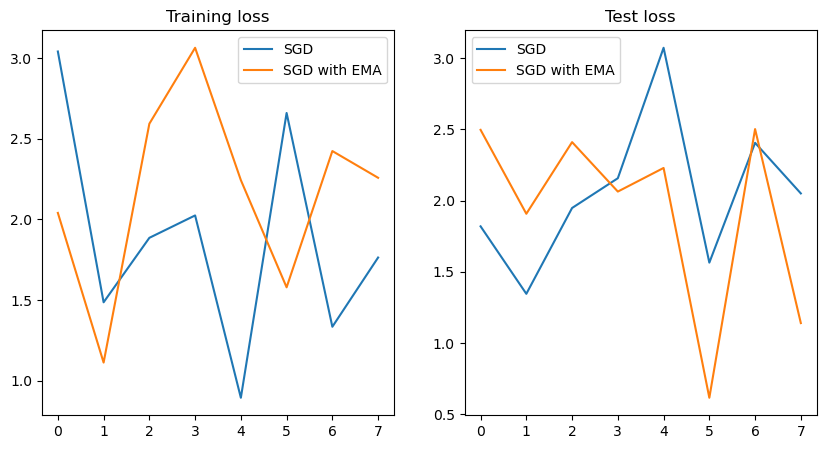

In [10]:
logs = np.asarray(logs)
logs_avg = np.asarray(logs_avg)

plt.subplots(1, 2, figsize=(10, 5))

plt.subplot(1, 2, 1)
# Plot training loss
plt.plot(logs[2:, 0], label='SGD')
plt.plot(logs_avg[2:, 0], label='SGD with EMA')
plt.title('Training loss')
plt.legend()

plt.subplot(1, 2, 2)
# Plot test loss
plt.plot(logs[2:, 1], label='SGD')
plt.plot(logs_avg[2:, 1], label='SGD with EMA')
plt.title('Test loss')
plt.legend()

# Bonus 2: Find divergent learning rate for this RNN model below. 
You do NOT need to know or understand RNN's for this problem, but if you are interested please check out the *optional* demo on Canvas on RNN's. In this exercise, we are just asking that you find the divergent learning rate for this model. The code created for you below, you will only need to use the code in the labeled code chunk to find the divergent learning rate and then use that learning rate to train the  model. No graphs are needed at the end. 


In [11]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])
torch.Size([5, 1, 59])


In [12]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = torch.nn.Linear(input_size + hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [13]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



In [14]:
import random
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Szewc
category = Czech / line = Kofron
category = Irish / line = Taidhg
category = Scottish / line = Gordon
category = Japanese / line = Taguchi
category = German / line = Strobel
category = Greek / line = Malihoudis
category = Irish / line = Mohan
category = Russian / line = Beh
category = Korean / line = Sung


# Use this code to find divergent learning rate!

In [15]:
criterion = torch.nn.NLLLoss()
rnn = RNN(n_letters, n_hidden, n_categories)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()
div_learning_rate = 0.02#TODO: Find the learning rate
learning_rate = 0.01
for iter in range(1, 20):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    print(f"Iteration {iter}: {loss}")


Iteration 1: 2.893557548522949
Iteration 2: 3.003159523010254
Iteration 3: 2.934823751449585
Iteration 4: 2.833251953125
Iteration 5: 2.928950309753418
Iteration 6: 2.9080727100372314
Iteration 7: 2.8792552947998047
Iteration 8: 2.8127939701080322
Iteration 9: 2.9635565280914307
Iteration 10: 2.9390127658843994
Iteration 11: 2.792665958404541
Iteration 12: 2.8479859828948975
Iteration 13: 2.993556022644043
Iteration 14: 2.95658278465271
Iteration 15: 2.942656993865967
Iteration 16: 2.9069480895996094
Iteration 17: 3.0185205936431885
Iteration 18: 2.921698570251465
Iteration 19: 2.768618106842041


In [16]:
import time
import math
rnn = RNN(n_letters, n_hidden, n_categories)
learning_rate = 0.01
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 2.2005 Bonnet / Dutch ✗ (French)
10000 10% (0m 5s) 2.5575 Cote / Korean ✗ (French)
15000 15% (0m 7s) 0.8297 Wehner / German ✓
20000 20% (0m 10s) 1.7053 Murphy / Irish ✗ (Scottish)
25000 25% (0m 12s) 0.0857 Ryzhikov / Russian ✓
30000 30% (0m 15s) 1.6413 Walker / Scottish ✓
35000 35% (0m 18s) 0.8997 Capello / Spanish ✓
40000 40% (0m 20s) 1.9551 Han / Chinese ✗ (Korean)
45000 45% (0m 23s) 0.5695 Portelli / Italian ✓
50000 50% (0m 26s) 0.0262 Yamakawa / Japanese ✓
55000 55% (0m 28s) 0.8693 Ola / Spanish ✓
60000 60% (0m 31s) 0.3735 Gianakopulos / Greek ✓
65000 65% (0m 35s) 0.1595 Zhelaev / Russian ✓
70000 70% (0m 37s) 3.0344 Yasmin / German ✗ (English)
75000 75% (0m 40s) 0.3023 Sokolowski / Polish ✓
80000 80% (0m 43s) 0.1863 Moon / Korean ✓
85000 85% (0m 46s) 0.7995 Huan / Chinese ✓
90000 90% (0m 48s) 0.0065 Bouloukos / Greek ✓
95000 95% (0m 51s) 1.2403 Michaud / Irish ✗ (French)
100000 100% (0m 54s) 0.4454 Melo / Portuguese ✓
